<a href="https://colab.research.google.com/github/JUNWEICHIN/ObjectDetection/blob/main/augmentation_bbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os
import glob
import math

In [2]:
def StandardImg(img, cords):
    cordsSTD = np.zeros(cords.shape)
    cordsSTD[:,0] = cords[:,0]*img.shape[1] - (cords[:,2]*img.shape[1])/2
    cordsSTD[:,1] = cords[:,1]*img.shape[0] - (cords[:,3]*img.shape[0])/2
    cordsSTD[:,2] = cords[:,0]*img.shape[1] + (cords[:,2]*img.shape[1])/2
    cordsSTD[:,3] = cords[:,1]*img.shape[0] + (cords[:,3]*img.shape[0])/2
    cords = cordsSTD
    return cords

In [3]:
def revert(img, cords):
    cordsRV = np.zeros(cords.shape)
    cordsRV[:,0] = ((cords[:,0]+cords[:,2])/2)/img.shape[1]
    cordsRV[:,1] = ((cords[:,1]+cords[:,3])/2)/img.shape[0]
    cordsRV[:,2] = (cords[:,2]-cords[:,0])/img.shape[1]
    cordsRV[:,3] = (cords[:,3]-cords[:,1])/img.shape[0]
    cords = cordsRV
    return cords

In [4]:
def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

In [5]:
class RandomHorizontalFlip(object):
    
    """Randomly horizontally flips the Image with the probability *p*
    
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
        
        
    Returns
    -------
    
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))
        if random.random() < self.p:
            img =  img[:,::-1,:]
            bboxes[:,[0,2]] += 2*(img_center[[0,2]] - bboxes[:,[0,2]])
            
            box_w = abs(bboxes[:,0] - bboxes[:,2])
             
            bboxes[:,0] -= box_w
            bboxes[:,2] += box_w
            
        return img, bboxes

In [6]:
class RandomVerticalFlip(object):
    
    """Randomly vertically flips the Image with the probability *p*
    
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
        
        
    Returns
    -------
    
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))
        if random.random() < self.p:
            img =  img[::-1, :, :]
            bboxes[:,[1,3]] += 2*(img_center[[1,3]] - bboxes[:,[1,3]])
            
            box_w = abs(bboxes[:,1] - bboxes[:,3])
             
            bboxes[:,1] -= box_w
            bboxes[:,3] += box_w
            
        return img, bboxes

In [7]:
def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

In [8]:
def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    
    Parameters
    ----------
    
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]


    return bbox

In [9]:
class RandomScale(object):
    """Randomly scales an image    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    scale: float or tuple(float)
        if **float**, the image is scaled by a factor drawn 
        randomly from a range (1 - `scale` , 1 + `scale`). If **tuple**,
        the `scale` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale = 0.2, diff = False):
        self.scale = scale

        
        if type(self.scale) == tuple:
            assert len(self.scale) == 2, "Invalid range"
            assert self.scale[0] > -1, "Scale factor can't be less than -1"
            assert self.scale[1] > -1, "Scale factor can't be less than -1"
        else:
            assert self.scale > 0, "Please input a positive float"
            self.scale = (max(-1, -self.scale), self.scale)
        
        self.diff = diff

    def __call__(self, img, bboxes):


        #Chose a random digit to scale by 

        img_shape = img.shape

        if self.diff:
          scale_x = random.uniform(*self.scale)
          scale_y = random.uniform(*self.scale)
        else:
          scale_x = random.uniform(*self.scale)
          scale_y = scale_x

          resize_scale_x = 1 + scale_x
          resize_scale_y = 1 + scale_y

          img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)

          bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]

          border_x = min(resize_scale_x,1)
          border_y = min(resize_scale_y,1)

          y_lim = int(min(resize_scale_y,1)*img_shape[0])
          x_lim = int(min(resize_scale_x,1)*img_shape[1])

          img = img[:y_lim,:x_lim,:]

          
          if border_x < 1 and border_y < 1:
              img = cv2.copyMakeBorder(img, 0, int(img_shape[0] - y_lim), 0, int(img_shape[1]-x_lim), cv2.BORDER_REPLICATE)
          elif border_x < 1 and border_y == 1:
              img = cv2.copyMakeBorder(img, 0, 0, 0, int(img_shape[1]-x_lim), cv2.BORDER_REPLICATE)
          elif border_x == 1 and border_y < 1:
              img = cv2.copyMakeBorder(img, 0, int(img_shape[0]- y_lim), 0, 0, cv2.BORDER_REPLICATE)
          else:
              img = img[:y_lim,:x_lim,:]
            
          img = img[:img_shape[0],:img_shape[1],:]

          bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)


          return img, bboxes

In [10]:
class RandomTranslate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate = 0.2, diff = True):
        self.translate = translate
        
        if type(self.translate) == tuple:
            assert len(self.translate) == 2, "Invalid range"  
            assert self.translate[0] > 0 & self.translate[0] < 1
            assert self.translate[1] > 0 & self.translate[1] < 1


        else:
            assert self.translate > 0 & self.translate < 1
            self.translate = (-self.translate, self.translate)
            
            
        self.diff = diff

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = random.uniform(*self.translate)
        translate_factor_y = random.uniform(*self.translate)
        
        if not self.diff:
            translate_factor_y = translate_factor_x
            
        canvas = np.zeros(img_shape).astype(np.uint8)


        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]

        T = np.float32([[1, 0, corner_x], [0, 1, corner_y]])
        img = cv2.warpAffine(img, T, (img_shape[1], img_shape[0]),borderMode = cv2.BORDER_REPLICATE)
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        

        

        
        return img, bboxes

In [11]:
def rotate_im(image, angle):
    """Rotate the image.
    
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    
    Parameters
    ----------
    
    image : numpy.ndarray
        numpy image
    
    angle : float
        angle by which the image is to be rotated
    
    Returns
    -------
    
    numpy.ndarray
        Rotated Image
    
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH), borderMode = cv2.BORDER_REPLICATE)

    # image = cv2.resize(image, (w,h))
    return image

In [12]:
def get_corners(bboxes):
    
    """Get corners of bounding boxes
    
    Parameters
    ----------
    
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`      
        
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

In [13]:
def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

In [14]:
def get_enclosing_box(corners):
    """Get an enclosing box for ratated corners of a bounding box
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`  
    
    Returns 
    -------
    
    numpy.ndarray
        Numpy array containing enclosing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final

In [15]:
class RandomRotate(object):
    """Randomly Rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float or tuple(float)
        if **float**, the image is rotated by a factor drawn 
        randomly from a range (-`angle`, `angle`). If **tuple**,
        the `angle` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle = 10):
        self.angle = angle
        
        if type(self.angle) == tuple:
            assert len(self.angle) == 2, "Invalid range"   
        else:
            self.angle = (-self.angle, self.angle)

    def __call__(self, img, bboxes):

        angle = random.uniform(*self.angle)

        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2

        img = rotate_im(img, angle)

        corners = get_corners(bboxes)

        corners = np.hstack((corners, bboxes[:,4:]))


        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)

        new_bbox = get_enclosing_box(corners)


        scale_factor_x = img.shape[1] / w

        scale_factor_y = img.shape[0] / h

        img = cv2.resize(img, (w,h))

        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 

        bboxes  = new_bbox

        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)

        return img, bboxes

In [16]:
class RandomHorizontalShear(object):
    """Randomly shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float or tuple(float)
        if **float**, the image is sheared horizontally by a factor drawn 
        randomly from a range (-`shear_factor`, `shear_factor`). If **tuple**,
        the `shear_factor` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
        if type(self.shear_factor) == tuple:
            assert len(self.shear_factor) == 2, "Invalid range for scaling factor"   
        else:
            self.shear_factor = (-self.shear_factor, self.shear_factor)
        
        shear_factor = random.uniform(*self.shear_factor)

    def __call__(self, img, bboxes):

        shear_factor = random.uniform(*self.shear_factor)

        w,h = img.shape[1], img.shape[0]

        if shear_factor < 0:
            img, bboxes = RandomHorizontalFlip(1)(img, bboxes)

        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])

        nW =  img.shape[1] + abs(shear_factor*img.shape[0])

        bboxes[:,[0,2]] += ((bboxes[:,[1,3]]) * abs(shear_factor) ).astype(int) 


        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]), borderMode = cv2.BORDER_REPLICATE)

        if shear_factor < 0:
          img, bboxes = RandomHorizontalFlip(1)(img, bboxes)

        img = cv2.resize(img, (w,h))

        scale_factor_x = nW / w

        bboxes[:,:4] /= [scale_factor_x, 1, scale_factor_x, 1] 


        return img, bboxes

In [17]:
class RandomVerticalShear(object):
    """Randomly shears an image in vertical direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float or tuple(float)
        if **float**, the image is sheared vertically by a factor drawn 
        randomly from a range (-`shear_factor`, `shear_factor`). If **tuple**,
        the `shear_factor` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
        if type(self.shear_factor) == tuple:
            assert len(self.shear_factor) == 2, "Invalid range for scaling factor"   
        else:
            self.shear_factor = (-self.shear_factor, self.shear_factor)
        
        shear_factor = random.uniform(*self.shear_factor)

    def __call__(self, img, bboxes):

        shear_factor = random.uniform(*self.shear_factor)

        w,h = img.shape[1], img.shape[0]

        if shear_factor < 0:
            img, bboxes = RandomVerticalFlip(1)(img, bboxes)

        M = np.array([[1, 0, 0],[abs(shear_factor),1,0]])

        nH =  img.shape[0] + abs(shear_factor*img.shape[1])

        bboxes[:,[1,3]] += ((bboxes[:,[0,2]]) * abs(shear_factor) ).astype(int) 


        img = cv2.warpAffine(img, M, (int(nH), img.shape[0]), borderMode = cv2.BORDER_REPLICATE)

        if shear_factor < 0:
          img, bboxes = RandomVerticalFlip(1)(img, bboxes)

        img = cv2.resize(img, (w,h))

        scale_factor_y = nH / h

        bboxes[:,:4] /= [1, scale_factor_y, 1, scale_factor_y] 


        return img, bboxes

In [18]:
class RandomHSV(object):
    """HSV Transform to vary hue saturation and brightness
    
    Hue has a range of 0-179
    Saturation and Brightness have a range of 0-255. 
    Chose the amount you want to change thhe above quantities accordingly. 
    
    
    
    
    Parameters
    ----------
    hue : None or int or tuple (int)
        If None, the hue of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-hue, hue) and added to the 
        hue of the image. If tuple, the int is sampled from the range 
        specified by the tuple.   
        
    saturation : None or int or tuple(int)
        If None, the saturation of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-saturation, saturation) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
        
    brightness : None or int or tuple(int)
        If None, the brightness of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-brightness, brightness) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
    
    Returns
    -------
    
    numpy.ndaaray
        Transformed image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, hue = None, saturation = None, brightness = None):
        if hue:
            self.hue = hue 
        else:
            self.hue = 0
            
        if saturation:
            self.saturation = saturation 
        else:
            self.saturation = 0
            
        if brightness:
            self.brightness = brightness
        else:
            self.brightness = 0
            
            

        if type(self.hue) != tuple:
            self.hue = (-self.hue, self.hue)
            
        if type(self.saturation) != tuple:
            self.saturation = (-self.saturation, self.saturation)
        
        if type(brightness) != tuple:
            self.brightness = (-self.brightness, self.brightness)
    
    def __call__(self, img, bboxes):

        hue = random.randint(*self.hue)
        saturation = random.randint(*self.saturation)
        brightness = random.randint(*self.brightness)
        
        img = img.astype(int)
        
        a = np.array([hue, saturation, brightness]).astype(int)
        img += np.reshape(a, (1,1,3))
        
        img = np.clip(img, 0, 255)
        img[:,:,0] = np.clip(img[:,:,0],0, 179)
        
        img = img.astype(np.uint8)

        
        
        return img, bboxes

In [19]:
def HorizontalFlip(img, bboxes):
    hor_flip = RandomHorizontalFlip(1)
    img_hflip, bboxes_hflip = hor_flip(img, bboxes.copy())
    return img_hflip, bboxes_hflip

In [20]:
def VerticalFlip(img, bboxes):
    ver_flip = RandomVerticalFlip(1)
    img_vflip, bboxes_vflip = ver_flip(img, bboxes.copy())
    return img_vflip, bboxes_vflip

In [21]:
def Rotation(img, bboxes):
    repeat = True
    while repeat:
        angle = random.randrange(30,90,10)
        rotation = RandomRotate(angle)
        img_rotation, bboxes_rotation = rotation(img, bboxes.copy())

        if bboxes_rotation.size != 0:
            repeat = False
    return img_rotation, bboxes_rotation

In [22]:
def HorizontalShear(img, bboxes):
    repeat = True
    while repeat:
        hor_shear = RandomHorizontalShear(1)
        img_hshear, bboxes_hshear = hor_shear(img, bboxes.copy())

        if bboxes_hshear.size != 0:
            repeat = False
    return img_hshear, bboxes_hshear

In [23]:
def VerticalShear(img, bboxes):
    repeat = True
    while repeat:
        ver_shear = RandomVerticalShear(1)
        img_vshear, bboxes_vshear = ver_shear(img, bboxes.copy())

        if bboxes_vshear.size != 0:
            repeat = False        
    return img_vshear, bboxes_vshear

In [24]:
def Translation(img, bboxes):
    repeat = True
    while repeat:
        translation = RandomTranslate(1)
        img_trans, bboxes_trans = translation(img, bboxes.copy())

        if bboxes_trans.size != 0:
            repeat = False            
    return img_trans, bboxes_trans

In [25]:
def ScaleOut(img, bboxes):
    repeat = True
    while repeat:
        scale_out = RandomScale((-0.3,0.35))
        img_oscale, bboxes_oscale = scale_out(img, bboxes.copy())
        
        if bboxes_oscale.size != 0:
            repeat = False
    return img_oscale, bboxes_oscale

In [26]:
def ScaleIn(img, bboxes):
    repeat = True
    while repeat:
        scale_in = RandomScale((0.1,0.35))
        img_iscale, bboxes_iscale = scale_in(img, bboxes.copy())
        
        if bboxes_iscale.size != 0:
            repeat = False
    return img_iscale, bboxes_iscale

In [27]:
def HueSaturationBrightness(img, bboxes):
    HSVRandomised = RandomHSV(10, 10, 35)
    img_HSV, bboxes_HSV = HSVRandomised(img, bboxes.copy())
    return img_HSV, bboxes_HSV

In [28]:
def Sequence(HSV, Probability, img, bboxes):
    
    if HSV > random.random():
        img, bboxes = HueSaturationBrightness(img, bboxes)
        print(HueSaturationBrightness)

    funclist = [HorizontalFlip, VerticalFlip, Rotation, ScaleOut, ScaleIn, Translation, HorizontalShear, VerticalShear]
    
    combined = list(zip(Probability,funclist))
    random.shuffle(combined)

    Probability, funclist = zip(*combined)
    i = 0
    Stop = 0
    Stop_factor = random.randint(1, 3)

    for func in funclist:

        if Probability[i] > random.random():
            img,bboxes = func(img,bboxes)
            print(func)
            Stop += 1

            if (Stop == Stop_factor):
                break

        i += 1

    return img, bboxes

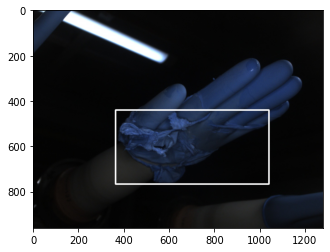

In [29]:
img_to_load = glob.glob('/content/drive/MyDrive/augmentation/test1/**/*.jpg',recursive = True)
bboxes_to_load = glob.glob('/content/drive/MyDrive/augmentation/test1/**/*.txt',recursive = True)

for i in range(len(img_to_load)):
    img = cv2.imread(img_to_load[i])[:,:,::-1]
    CLbboxes = np.loadtxt(bboxes_to_load[i], delimiter=" ")
    CLbboxes = np.vstack((CLbboxes, CLbboxes))
    Class = CLbboxes[:,0]
    bboxes = CLbboxes[:,1:]
    bboxes = StandardImg(img, bboxes)
    plt.imshow(draw_rect(img, bboxes))

In [30]:
img_to_load = glob.glob('/content/drive/MyDrive/augmentation/test/**/*.jpg',recursive = True)
bboxes_to_load = glob.glob('/content/drive/MyDrive/augmentation/test/**/*.txt',recursive = True)

img_to_generate = 5
count = 0
number = img_to_generate*len(img_to_load)

while i in range(len(img_to_load)):
    while count < img_to_generate:
        img = cv2.imread(img_to_load[i])[:,:,::-1]
        CLbboxes = np.loadtxt(bboxes_to_load[i], delimiter=" ")
        CLbboxes = np.vstack((CLbboxes, CLbboxes))
        Class = CLbboxes[:,0]
        bboxes = CLbboxes[:,1:]
        bboxes = StandardImg(img, bboxes)
        
        augmented_path = r"/content/drive/MyDrive/augmentation/result1/"

        imgC, bboxesC = Sequence(0.1,[0,0,1,0,0,0,0,0], img, bboxes.copy())

        new_image_path = "%s/augmented_image_%s_%s.jpg"%(augmented_path,i,number)
        transformed_image = cv2.cvtColor(imgC,cv2.COLOR_BGR2RGB)
        cv2.imwrite(new_image_path, transformed_image)
        Name_of_textfile = "%s/augmented_image_%s_%s.txt"%(augmented_path,i,number)
        bboxesC = revert(imgC,bboxesC)
        Class = Class.reshape(-1,1)
        CLbboxes = np.hstack((Class, bboxesC))
        rows_to_remove = int(CLbboxes.shape[0]/2)
        CLbboxes = CLbboxes[:rows_to_remove,:]
        file = open(Name_of_textfile,"w")
        np.savetxt(file,CLbboxes,fmt='%i %1.6f %1.6f %1.6f %1.6f',delimiter='\t')
        file.close()


        if count == 4:
            count = 0
            i += 1
            number -= 1
        else:
            count += 1
            number -= 1
        


<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function HueSaturationBrightness at 0x7fd4012279e0>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function HueSaturationBrightness at 0x7fd4012279e0>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation at 0x7fd4011edb90>
<function Rotation a

KeyboardInterrupt: ignored